# Project ML / DSA : Sentiment Analysis dengan Hybrid ANN-NB Classifier

### Read Feature (Text) and Target (Rating)

In [1]:
from sklearn.datasets import load_files
import numpy as np

reviews = load_files("dataset", encoding="ISO-8859-1")
texts, rating = reviews.data, reviews.target

### Preprocessing

In [2]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_texts(texts):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]) for text in texts]

def stem_texts(texts):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(w) for w in nltk.word_tokenize(text)]) for text in texts]

### Custom Test-Train Text Split Method

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split as tts

def train_test_text_split(X, y, test_size=0.25):
    # normal split
    text_train, text_test, y_train, y_test = tts(stem_texts(X), y, test_size=test_size)
    
    # define tokenizer
    token = RegexpTokenizer(r'[a-zA-Z0-9]+')

    # define the vectorizer
    vect = CountVectorizer(min_df=5, lowercase=True,
                           stop_words='english',
                           ngram_range = (1,1),
                           tokenizer = token.tokenize,
                            max_features=100)
    
    # vectorize text
    X_train = vect.fit(text_train).transform(text_train).todense()
    X_test = vect.transform(text_test).todense()
    
    return X_train, X_test, y_train, y_test
    

### Vectorizing Text to get the trainable features

In [4]:
# transform text into trainable vectors
X_train, X_test, y_train, y_test = train_test_text_split(texts, rating, test_size=0.25)

### Building The ANN Classifier

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import numpy as np

def create_ann_clf(feature_count, num_classes):
    classifier = Sequential()
    hidden_units = (feature_count + 1) // 2
    classifier.add(Dense(output_dim = hidden_units, init = 'uniform', 
                         activation = 'relu', input_dim = feature_count))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(output_dim = hidden_units, activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(output_dim = num_classes, init = 'uniform', 
                         activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                       metrics = ['accuracy'])
    return classifier


Using TensorFlow backend.


### Create the Hybrind ANN-NB class

In [6]:
from sklearn.naive_bayes import MultinomialNB

class HybridANNBayesClassifier:
    
    def __init__(self):
        self.bayes_model = MultinomialNB()
        
    def get_x_with_dk(self, X):
        domain_knowledge = self.ann_model.predict(X)
        return np.concatenate([np.array(X),np.matrix(np.argmax(domain_knowledge, axis=1)).transpose()], axis=1)
    
    def fit(self, X, y):
        # cons len is used when we want to count the learning curve
        self.ann_model = create_ann_clf(X.shape[1], len(set(y)))
        self.ann_model.fit(X, to_categorical(y))
        self.bayes_model.fit(self.get_x_with_dk(X), y)
        
    def score(self, X, y):
        return self.bayes_model.score(self.get_x_with_dk(X), y)
    
    def predict(self, X):
        return self.bayes_model.predict(self.get_x_with_dk(X))        

### Comparison

Beside Baseline (Dummy Classifier) and Hybrid ANN-NB, there are 3 other algorithm that'll be used for comparison. They are Logistic Regression, MLPClassifier (ANN), and Naive Bayes.

#### Performance Report Method

In [7]:
import numpy as np
def report_performance(report):
    for model, scores in report.items():
        print("Model: ", model)
        print("Max: ", np.max(scores))
        print("Min: ", np.min(scores))
        print("Avg: ", np.mean(scores))
        print()

#### Model Performance Measuring Method (complete with cross validation)

In [8]:
def compare_performances(models, X, y, cv=3):
    scores = {}
    
    # initiate scores
    for name in models:
        scores[name] = []
        
    # cross-validate as demanded
    for i in range(cv):
        
        # all models use the same train-test data per cv
        X_train, X_test, y_train, y_test = train_test_text_split(X, y, test_size=0.25)
        
        # iterate all models
        for name, model in models.items():
            model.fit(X_train,y_train)
            scores[name].append(model.score(X_test, y_test))
    return scores

#### Defining Models

Aside from Hybrid ANN-NB model, all other model are used from sklearn library

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

models = {'Baseline': DummyClassifier(),
          'HybridANN-NB': HybridANNBayesClassifier(),
          'ANN': MLPClassifier(),
          'Naive Bayes': MultinomialNB(),
          'Logistic Regression': LogisticRegression()
         }

#### Measure all models

In [10]:
report = compare_performances(models, texts, rating, cv=10)

C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50)`
  del sys.path[0]
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`
  app.launch_new_instance()


Epoch 1/1
1413/1413 [==============================] - 1s 1ms/step - loss: 1.5802 - acc: 0.3199


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5695 - acc: 0.3248


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 1s 1ms/step - loss: 1.5869 - acc: 0.3128


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5836 - acc: 0.3135


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5803 - acc: 0.2979


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5791 - acc: 0.3079


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5832 - acc: 0.3022


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5721 - acc: 0.3263


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5729 - acc: 0.2909


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site

Epoch 1/1
1413/1413 [==============================] - 2s 1ms/step - loss: 1.5854 - acc: 0.3178


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### Performance Report

In [11]:
report_performance(report)

Model:  Baseline
Max:  0.2627118644067797
Min:  0.2245762711864407
Avg:  0.24258474576271186

Model:  HybridANN-NB
Max:  0.4830508474576271
Min:  0.4046610169491525
Avg:  0.4398305084745762

Model:  ANN
Max:  0.4682203389830508
Min:  0.3580508474576271
Avg:  0.40338983050847455

Model:  Naive Bayes
Max:  0.4830508474576271
Min:  0.4046610169491525
Avg:  0.43792372881355934

Model:  Logistic Regression
Max:  0.4788135593220339
Min:  0.4046610169491525
Avg:  0.4389830508474576



### Learning Curve

DISCLAIMER : This is not my original code
    
source : https://gist.github.com/adrialuzllompart/c916c4ce3782a98ab5c92fe82ce0d293#file-plot_learning_curves-py

In [12]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_learning_curves(estimator, X_train, y_train, X_val, y_val,
                         suptitle='', title='', xlabel='', ylabel='', baseline=DummyClassifier()):
    """
    Plots learning curves for a given estimator.
    Parameters
    ----------
    estimator : sklearn estimator
    X_train : list
        training set (features)
    y_train : list
        training set (response)
    X_val : list
        validation set (features)
    y_val : list
        validation set (response)
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []
    base_score = []
    
    # at least we want a minimum of sample that has all the classes
    min_sample = 0
    for i in range(len(y_train)):
        if len(set(y_train[0:i])) >= len(set(y_test)):
            min_sample = i + 1
            break
            
            
    # create ten incremental training set sizes
    training_set_sizes = np.linspace(min_sample, len(X_train), 5, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        # fit the model only using that many training examples
        estimator.fit(X_train[0:i, :], y_train[0:i])
        baseline.fit(X_train[0:i, :], y_train[0:i])
        # calculate the training accuracy only using those training examples
        train_accuracy = estimator.score(X_train[0:i, :], y_train[0:i])
        # calculate the validation accuracy using the whole validation set
        val_accuracy = estimator.score(X_val,y_val)
        # calculate the baseline accuracy using the whole validation set
        base_accuracy = baseline.score(X_val,y_val)
        # store the scores in their respective lists
        train_score.append(train_accuracy)
        val_score.append(val_accuracy)
        base_score.append(base_accuracy)
        print(i, " Samples done")
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='green')
    ax.plot(training_set_sizes, base_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training score', 'testing score', 'baseline score'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = FuncFormatter(percentages)
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = FuncFormatter(numbers)
    ax.xaxis.set_major_formatter(x_formatter)

C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50)`
  del sys.path[0]
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`
  app.launch_new_instance()


Epoch 1/1
9/9 [==============================] - 2s 191ms/step - loss: 1.6148 - acc: 0.1111
9  Samples done


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50)`
  del sys.path[0]
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`
  app.launch_new_instance()


Epoch 1/1
360/360 [==============================] - 2s 7ms/step - loss: 1.6102 - acc: 0.1833
360  Samples done


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50)`
  del sys.path[0]
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`
  app.launch_new_instance()


Epoch 1/1
711/711 [==============================] - 2s 3ms/step - loss: 1.5964 - acc: 0.3024
711  Samples done


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50)`
  del sys.path[0]
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`
  app.launch_new_instance()


Epoch 1/1
1062/1062 [==============================] - 2s 2ms/step - loss: 1.5846 - acc: 0.3089
1062  Samples done


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=100, units=50, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=50)`
  del sys.path[0]
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`
  app.launch_new_instance()


Epoch 1/1
1413/1413 [==============================] - 2s 2ms/step - loss: 1.5798 - acc: 0.3093
1413  Samples done


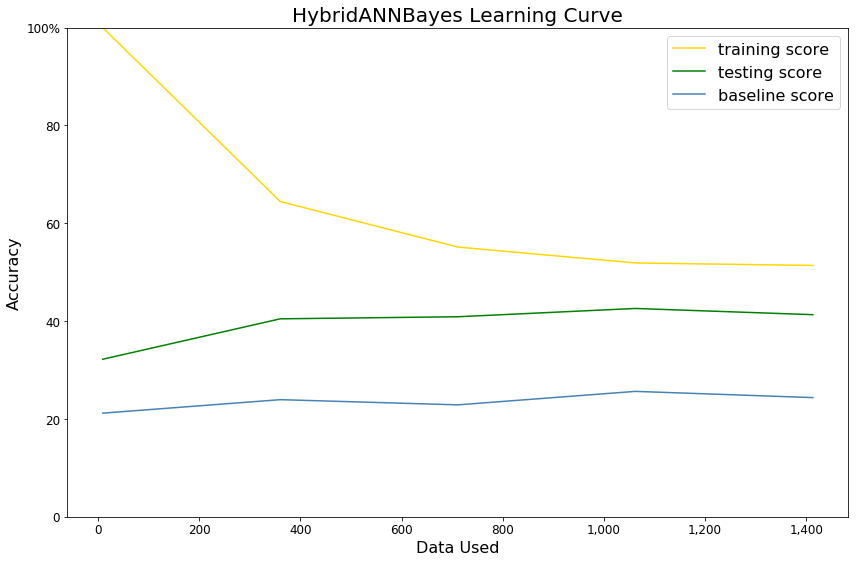

In [13]:
X_train, X_test, y_train, y_test = train_test_text_split(texts, rating, test_size=0.25)
hybrid_model = HybridANNBayesClassifier()

plot_learning_curves(hybrid_model, X_train, y_train, X_test, y_test,
                         suptitle='', title='HybridANNBayes Learning Curve', xlabel='Data Used', ylabel='Accuracy')